# Notebook 12
In this notebook, we test basic predictive modelling approaches without any spatial encoding


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

import pyproj as proj
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
import data_processing_helper as dp
import practical_functions as pf
import geoplot as gplt
import warnings
from matplotlib import cm
warnings.filterwarnings("ignore")


###
# For categorical encoding
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
# Compute the distances between all surveys 
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import ward, fcluster
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,  cross_val_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import ValidationCurve
from sklearn.model_selection import RepeatedKFold


import statsmodels.api as sm
from sklearn import tree

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

from statistics import mean, stdev




In [6]:
df = pd.read_csv("../Data/Final_dataframe_30_05.csv")
df_untouched = df

In [3]:
# Keep only the country code
df.drop(columns = ["Local", "Regional", "State", "country_code"], inplace = True)


In [4]:
y = df["pr_hard_coral"]
X = df.drop(columns = ["pr_hard_coral", "geometry"])

In [6]:
# In order to have a gaussian distribution
y_sqrt = np.sqrt(y)

<AxesSubplot:title={'center':'Missing values data '}>

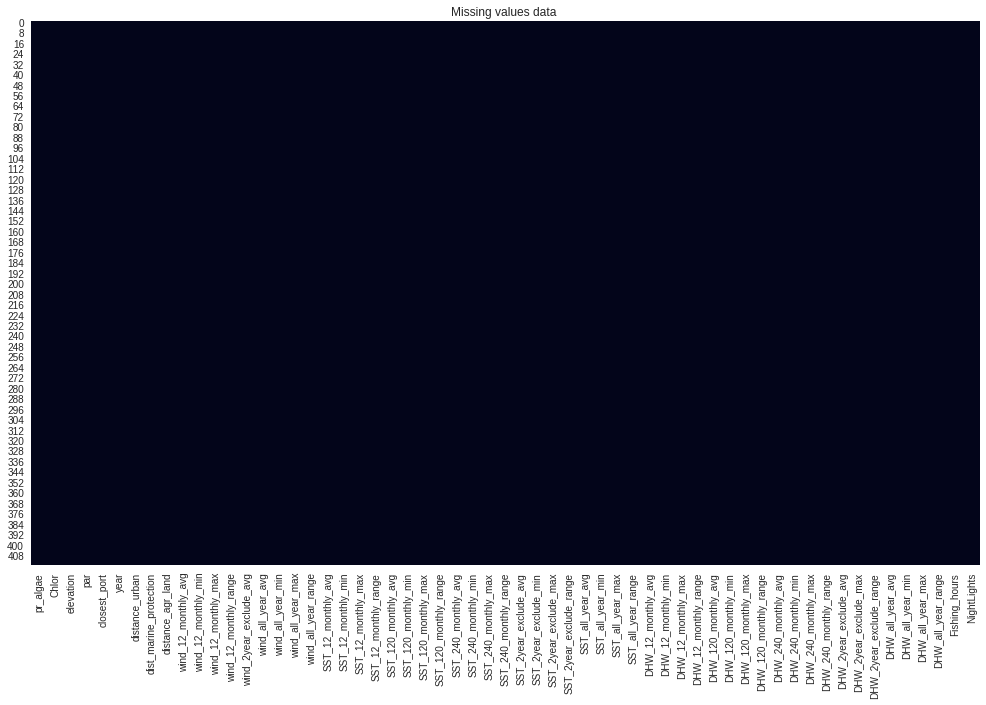

In [7]:
plt.figure(figsize = (17,10))
plt.title("Missing values data ")
sns.heatmap(X.isnull(), cbar=False)


In [8]:
# One hot encding for country code 


Pre-processing: This is not necessar< because I used a standard scalar

- sqrt for target variable, for distance urban ,dist_marine_protection, DHW120 monthy,DHW12 monthy,DHW_240_monthly_avg, Fishing Hours, Nighlights
- No change to closest port, PAR, elevation (debatable)
- log transform for distance_agr_land
- 

In [9]:
X.describe()

,pr_algae,Chlor,elevation,par,closest_port,year,distance_urban,dist_marine_protection,distance_agr_land,wind_12_monthly_avg,...,DHW_240_monthly_range,DHW_2year_exclude_avg,DHW_2year_exclude_max,DHW_2year_exclude_range,DHW_all_year_avg,DHW_all_year_min,DHW_all_year_max,DHW_all_year_range,Fishing_hours,NightLights
count,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,4.160000e+02,416.000000,...,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000
mean,0.639331,0.440010,-28.653846,47.258668,401.539839,2014.367788,95089.552004,55787.185829,2.285040e+05,6.325475,...,4.255713,0.498397,2.691535,2.691535,0.251066,0.251066,0.251066,0.251066,199.371571,0.072752
std,0.128188,0.505566,74.281233,7.442807,154.543193,1.979855,65295.323434,54458.803572,3.187465e+05,2.098232,...,2.909539,0.597814,2.993379,2.993379,0.118519,0.118519,0.118519,0.118519,378.906998,0.185176
min,0.245500,0.055417,-820.000000,32.211998,14.224993,2012.000000,1957.900081,485.485645,4.268480e+04,1.777110,...,1.300000,0.000000,0.000000,0.000000,0.089855,0.089855,0.089855,0.089855,0.000000,0.000000
25%,0.550375,0.149483,-34.000000,41.583499,297.682508,2012.000000,42331.961058,20367.960556,9.054385e+04,4.861870,...,2.681429,0.179791,0.988333,0.988333,0.151882,0.151882,0.151882,0.151882,0.000000,0.003203
50%,0.647950,0.255607,-9.500000,45.347999,417.432869,2014.000000,72111.708063,36986.452699,1.391616e+05,7.212334,...,3.142500,0.291098,1.650000,1.650000,0.232769,0.232769,0.232769,0.232769,0.000000,0.042478
75%,0.732350,0.471203,-2.000000,54.748000,517.366122,2016.000000,148638.802908,61214.883014,2.209613e+05,7.996352,...,5.428929,0.599013,3.110000,3.110000,0.331096,0.331096,0.331096,0.331096,134.829200,0.066105
max,0.907000,4.310281,162.000000,61.114000,748.780649,2018.000000,246168.835815,234101.388622,1.664402e+06,8.862575,...,12.446000,3.075459,12.446000,12.446000,0.645722,0.645722,0.645722,0.645722,1461.022700,1.929311


In [10]:
# Standardize the Data
data_scaler = StandardScaler().fit(X.values)
data_rescaled = data_scaler.transform(X.values)
X_scaled = pd.DataFrame(data_rescaled)
X_scaled.columns = X.columns

In [11]:
X_simple = X_scaled[["DHW_12_monthly_avg", "DHW_120_monthly_avg", "DHW_240_monthly_avg"]]

In [12]:
X_add = X_scaled[['Chlor', 'elevation', 'par', 'closest_port',
       'distance_urban', 'dist_marine_protection', 'distance_agr_land',
       'DHW_12_monthly_avg','DHW_120_monthly_avg','DHW_240_monthly_avg', 'Fishing_hours',
       'NightLights']]

In [14]:
X_corr = X_add.join(y)

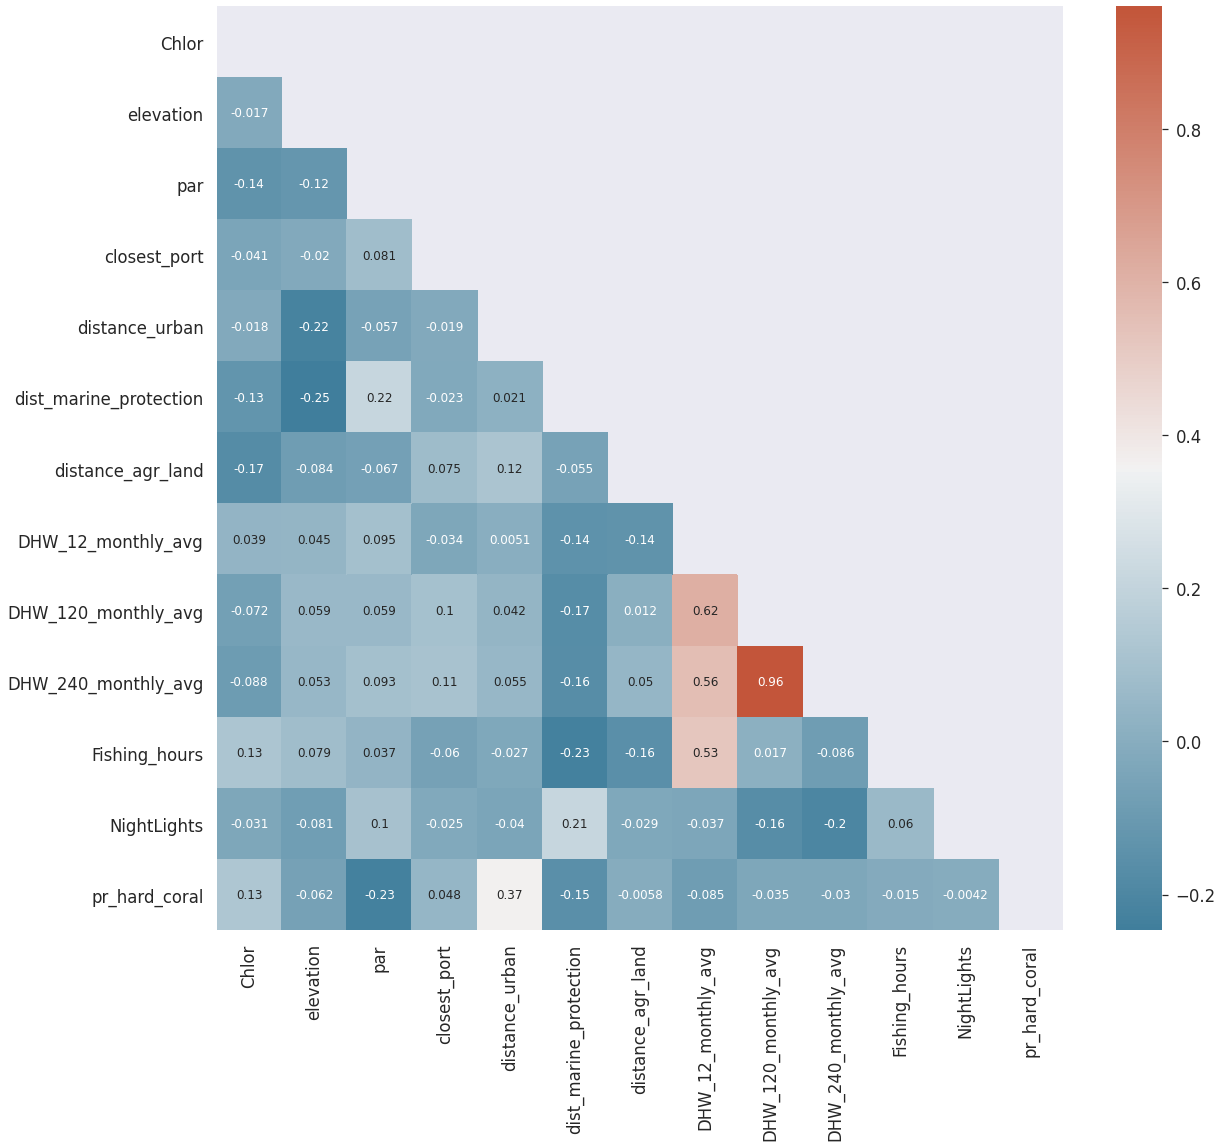

In [29]:
corr = X_corr.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(21, 17))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap, annot_kws={"size": 12})
sns.set(font_scale = 1.5)
f.subplots_adjust(left=0.2)
f.savefig('corr.png')


## Careful when using K-fold because the data appears in a certain order, it must thus be shuffled

Might be better to use stratified K-fold in order to keep classes in both trian nad test

In [12]:

def K_cross_validation(x,y, model, logistic_model = False):
    # Create StratifiedKFold object.
    skf = RepeatedKFold(n_splits=12,  random_state=1, n_repeats=5)
    lst_accu_stratified = []

    for train_index, test_index in skf.split(x, y):
        
    
        x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        col_drop = x_train_fold.loc[:,x_train_fold.std() == 0].columns

        # Remove columns with zero standard deviation
        x_train_fold.drop(columns = col_drop, inplace = True)
        x_test_fold.drop(columns = col_drop, inplace = True)
        model.fit(x_train_fold, y_train_fold)
        if (logistic_model):
            y_pred = model.predict(x_test_fold)
            lst_accu_stratified.append(r2_score(y_test_fold, y_pred))
            
        else:
            lst_accu_stratified.append(model.score(x_test_fold, y_test_fold))
        


    
    print('\nMaximum that can be obtained from this model is:',
          max(lst_accu_stratified), 'R^2')
    print('\nMinimum :',
          min(lst_accu_stratified), 'R^2')
    print('\nOverall :',
          mean(lst_accu_stratified), 'R^2')
    print('\nStandard deviation is:', stdev(lst_accu_stratified), '\n')

## Linear regression 

In [13]:
i = 50
model = linear_model.Ridge(alpha = i, normalize = False,fit_intercept=True)
print(" ------------- Linear model with regression for environmental data -------------\n")
K_cross_validation(X_simple, y_sqrt, model)


model = linear_model.Ridge(alpha = i,normalize = False,fit_intercept=True)
print(" ------------- Linear model with regression for anthropological data -------------\n")
K_cross_validation(X_add, y_sqrt, model)


 ------------- Linear model with regression for environmental data -------------


Maximum that can be obtained from this model is: 0.03384680631502901 R^2

Minimum : -0.29261686697097433 R^2

Overall : -0.03468760159486148 R^2

Standard deviation is: 0.055659280773046625 

 ------------- Linear model with regression for anthropological data -------------


Maximum that can be obtained from this model is: 0.3555632555634578 R^2

Minimum : -0.19284554996268755 R^2

Overall : 0.15189675043468567 R^2

Standard deviation is: 0.1353081482849961 



## Tree Regressor

Max_depth


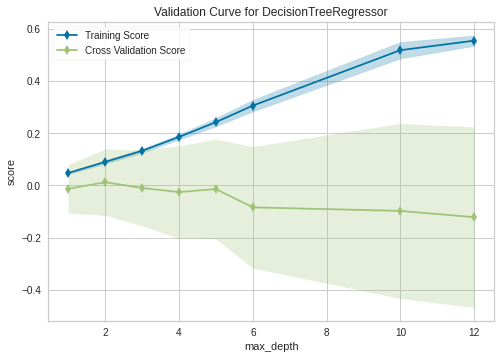

In [14]:
print("Max_depth")
cv = RepeatedKFold(n_splits=15, n_repeats=20)
param_range = [1,2,3, 4,5,6,10,12]

viz = ValidationCurve(DecisionTreeRegressor(), param_name="max_depth", param_range=param_range, cv=cv, scoring="r2", n_jobs=-1)

viz.fit(X_simple, y_sqrt)
viz.show()
plt.show()

Max_depth


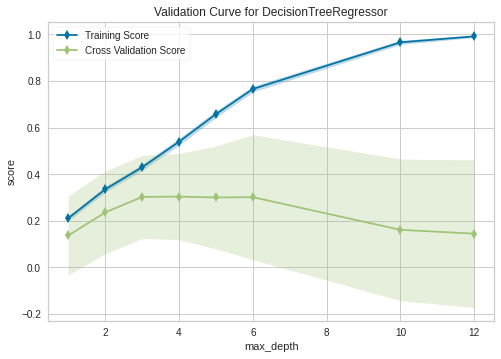

In [15]:
print("Max_depth")
cv = RepeatedKFold(n_splits=15, n_repeats=12)
param_range = [1,2,3, 4,5,6,10,12]

viz = ValidationCurve(DecisionTreeRegressor(), param_name="max_depth", param_range=param_range, cv=cv, scoring="r2", n_jobs=-1)

viz.fit(X_add, y_sqrt)
viz.show()
plt.show()

min_samples_split


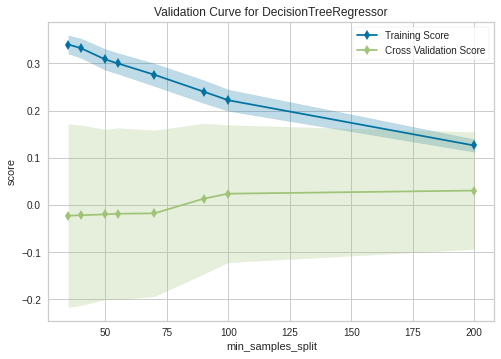

In [16]:
print("min_samples_split")
cv = RepeatedKFold(n_splits=12, n_repeats=15)
param_range = [35, 40,50, 55, 70, 90, 100,200]

viz = ValidationCurve(DecisionTreeRegressor(), param_name="min_samples_split", param_range=param_range, cv=cv, scoring="r2", n_jobs=-1)

viz.fit(X_simple, y_sqrt)
viz.show()
plt.show()

min_samples_split


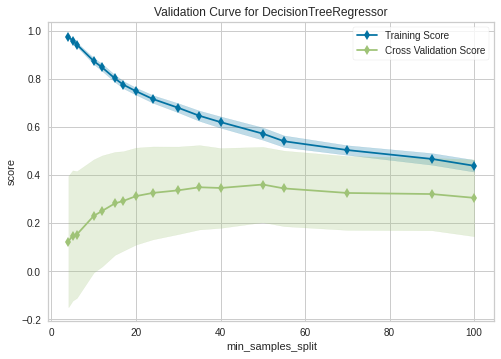

In [17]:
print("min_samples_split")
cv = RepeatedKFold(n_splits=12, n_repeats=15)
param_range = [4,5,6,10,12, 15, 17, 20, 24,30, 35, 40,50, 55, 70, 90, 100]

viz = ValidationCurve(DecisionTreeRegressor(), param_name="min_samples_split", param_range=param_range, cv=cv, scoring="r2", n_jobs=-1)

viz.fit(X_add, y_sqrt)
viz.show()
plt.show()

In [18]:


print("Environemtal MODEL")
model = DecisionTreeRegressor(criterion = "mse",max_depth=2, min_samples_split = 100)
K_cross_validation(X_simple, y_sqrt, model)

print("Anthropological MODEL")
model = DecisionTreeRegressor(criterion = "mse",max_depth=4, min_samples_split = 50)

K_cross_validation(X_add, y_sqrt, model)


Environemtal MODEL

Maximum that can be obtained from this model is: 0.19500308968489277 R^2

Minimum : -0.44954981715087383 R^2

Overall : 0.02343756106864992 R^2

Standard deviation is: 0.1188494935300551 

Anthropological MODEL

Maximum that can be obtained from this model is: 0.603509313786647 R^2

Minimum : -0.10162518439174684 R^2

Overall : 0.33659887037177955 R^2

Standard deviation is: 0.13784310325431112 



## Logistic regression

In [19]:
class LogitRegression(LinearRegression):

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)

In [20]:


print("Environemtal MODEL")
model = LogitRegression()

#print(" ------------- Linear model without regression for environmental data -------------\n")
K_cross_validation(X_simple, y_sqrt, model, logistic_model= True)

print("Anthropological MODEL")
model = LogitRegression()

#print(" ------------- Linear model without regression for environmental data -------------\n")
K_cross_validation(X_add, y_sqrt, model, logistic_model= True)





Environemtal MODEL

Maximum that can be obtained from this model is: 0.03349982073548041 R^2

Minimum : -0.3561895425398254 R^2

Overall : -0.043416387853900916 R^2

Standard deviation is: 0.06304584578845256 

Anthropological MODEL

Maximum that can be obtained from this model is: 0.38915176163272147 R^2

Minimum : -0.20047775030370163 R^2

Overall : 0.13670350882379895 R^2

Standard deviation is: 0.15935606936592772 



In [13]:
# Because balanced data set, no need to stratify
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X_simple, y_sqrt, test_size=0.20)
X_train, X_test, y_train, y_test = train_test_split(X_add, y_sqrt, test_size=0.20)

<AxesSubplot:xlabel='DHW_12_monthly_avg', ylabel='Density'>

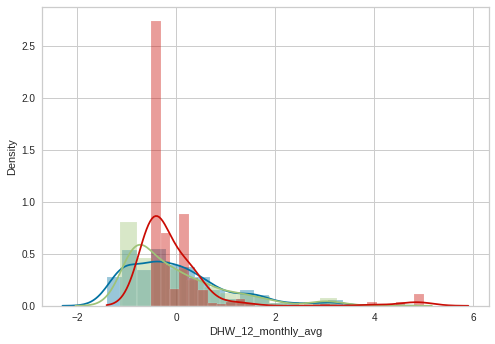

In [14]:
sns.distplot(X_simple["DHW_240_monthly_avg"])
sns.distplot(X_simple["DHW_120_monthly_avg"])
sns.distplot(X_simple["DHW_12_monthly_avg"])

In [15]:
col_drop_simple = X_train_simple.loc[:,X_train_simple.std() == 0].columns

col_drop_full = X_train.loc[:,X_train.std() == 0].columns
# Remove columns with zero standard deviation
X_train_simple.drop(columns = col_drop_simple, inplace = True)
X_train.drop(columns = col_drop_full, inplace = True)
X_test_simple.drop(columns = col_drop_simple, inplace = True)
X_test.drop(columns = col_drop_full, inplace = True)

### Linear Regression
Limitations:
- Not bounded !

Scored:
Return the coefficient R² of determination of the prediction. (best = 1)


In [18]:
reg = LinearRegression(normalize = False,fit_intercept=True).fit(X_train_simple, y_train_simple)
y_train_simple_pred = reg.predict(X_train_simple)
y_test_simple_pred = reg.predict(X_test_simple)


print("Simple")
print("R² Train without regularization = ",reg.score(X_train_simple, y_train_simple))
print("R² Test without regularization  = ",reg.score(X_test_simple, y_test_simple))
print("MAE score")
print("MAE Train without reg= ", mean_absolute_error(y_train_simple, y_train_simple_pred))
print("MAE Test without reg= ", mean_absolute_error(y_test_simple, y_test_simple_pred))

# With Regu
reg = linear_model.Ridge(alpha=.8,normalize = False,fit_intercept=True).fit(X_train_simple, y_train_simple)
y_train_simple_pred = reg.predict(X_train_simple)
y_test_simple_pred = reg.predict(X_test_simple)
print("R² Train with regularization  = ",reg.score(X_train_simple, y_train_simple))
print("R² Test with regularization  = ",reg.score(X_test_simple, y_test_simple))
print("MAE score")
print("MAE Train with reg= ", mean_absolute_error(y_train_simple, y_train_simple_pred))
print("MAE Test with reg= ", mean_absolute_error(y_test_simple, y_test_simple_pred))

Simple
R² Train without regularization =  0.006075231967644368
R² Test without regularization  =  0.002915017844765
MAE score
MAE Train without reg=  0.08973950058363978
MAE Test without reg=  0.09511375167599073
R² Train with regularization  =  0.006074693463528402
R² Test with regularization  =  0.0028584814610012055
MAE score
MAE Train with reg=  0.08974199335354639
MAE Test with reg=  0.09512090960189168


In [19]:
# With added data
reg = LinearRegression(normalize = False,fit_intercept=True).fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
print("Added data")
print("R² Train without regularization = ",reg.score(X_train, y_train))
print("R² Test without regularization = ",reg.score(X_test, y_test))

print("MAE score")
print("MAE Train without reg= ", mean_absolute_error(y_train, y_train_pred))
print("MAE Test without reg= ", mean_absolute_error(y_test, y_test_pred))
# With Regu
reg = linear_model.Ridge(alpha=.8,normalize = False,fit_intercept=True).fit(X_train, y_train)
print("R² Train with regularization = ",reg.score(X_train, y_train))
print("R² Test with regularization = ",reg.score(X_test, y_test))
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

print("MAE score")
print("MAE Train with reg = ", mean_absolute_error(y_train_simple, y_train_pred))
print("MAE Test with reg= ", mean_absolute_error(y_test_simple, y_test_pred))


Added data
R² Train without regularization =  0.21503756766745574
R² Test without regularization =  0.2221303344098392
MAE score
MAE Train without reg=  0.07873642137612065
MAE Test without reg=  0.07764230868301888
R² Train with regularization =  0.21503506587973908
R² Test with regularization =  0.22240275504277873
MAE score
MAE Train with reg =  0.0991342063803471
MAE Test with reg=  0.10948812833132719


## Decision Tree Regressor 

Criterion = MSE (wouldn't MAE be better ?)

Simple Model
 Training Model

R-Squared on train dataset=0.13852187096091195

Accuracy of Train Data with cross validation 
 : [-0.10355122 -0.03866908  0.09619596  0.14088617 -0.06584537  0.10770125
  0.11521755  0.17325077 -0.18393977 -0.01257428]

Test model

R-Squared on test dataset=0.2577033921827442

Accuracy of Test Data : [-0.19828509 -0.35521408  0.52651971 -0.52711249  0.46629792 -1.6565983
 -0.96929584 -0.81369858 -1.47555794 -3.45319241]


<AxesSubplot:>

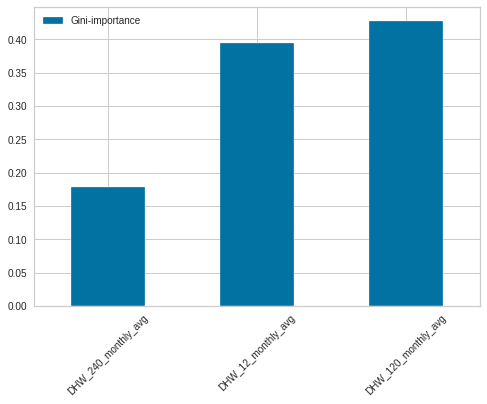

In [22]:
DTR = DecisionTreeRegressor(criterion = "mse",max_depth=3).fit(X_train_simple, y_train_simple)
print("Simple Model\n Training Model\n")
print("R-Squared on train dataset={}".format(DTR.score(X_train_simple,y_train_simple)))
print('\nAccuracy of Train Data with cross validation \n :', cross_val_score(DTR, X_train_simple,y_train_simple, cv=10 ))
print("\nTest model\n")
DTR.fit(X_test_simple,y_test_simple)   
print("R-Squared on test dataset={}".format(DTR.score(X_test_simple,y_test_simple)))
print('\nAccuracy of Test Data :', cross_val_score(DTR, X_test_simple,y_test_simple, cv=10 ))

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_simple.columns, DTR.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

Added data Model
 Training Model

R-Squared on train dataset=0.4204818006119061

Accuracy of Train Data with cross validation 
 : [0.31754124 0.16551531 0.42470307 0.43499424 0.21282796 0.20904245
 0.32223111 0.47936326 0.49940462 0.09738796]

Test model

R-Squared on test dataset=0.609036090448259

Accuracy of Test Data : [ 0.37831814 -1.13879559 -1.44330906  0.04719206 -1.05540885 -0.22960939
  0.34757124  0.05555661 -1.75970316 -0.749482  ]


<AxesSubplot:>

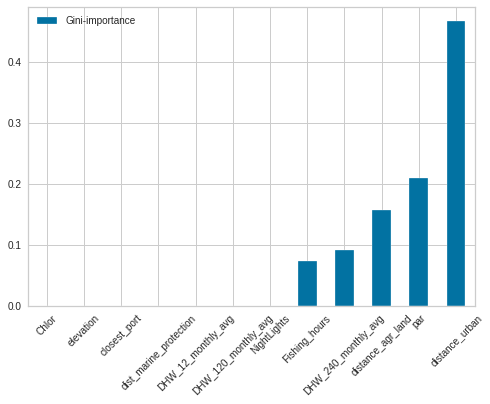

In [23]:
DTR = DecisionTreeRegressor(criterion = "mse",max_depth=3).fit(X_train, y_train)
print("Added data Model\n Training Model\n")
print("R-Squared on train dataset={}".format(DTR.score(X_train,y_train)))
print('\nAccuracy of Train Data with cross validation \n :', cross_val_score(DTR, X_train,y_train, cv=10 ))
print("\nTest model\n")
DTR.fit(X_test,y_test)   
print("R-Squared on test dataset={}".format(DTR.score(X_test,y_test)))
print('\nAccuracy of Test Data :', cross_val_score(DTR, X_test,y_test, cv=10 ))

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, DTR.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

## Logistic workaround ?
- Limitations

Need for adding regularization ? 

In [37]:

class LogitRegression(LinearRegression):

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)



In [48]:

model = LogitRegression()
model.fit(X_train_simple, y_train_simple)

y_train_pred_simple = model.predict(X_train_simple)
y_test_pred_simple = model.predict(X_test_simple)

print("Simple model R² score\n")
print("Train = ", r2_score(y_train_simple, y_train_pred_simple))
print("Test = ", r2_score(y_test_simple, y_test_pred_simple))

print("\nSimple model MAE score\n")
print("Train = ", mean_absolute_error(y_train_simple, y_train_pred_simple))
print("Test = ", mean_absolute_error(y_test_simple, y_test_pred_simple))




Simple model R² score

Train =  0.008017413825851305
Test =  -0.03170248171344814

Simple model MAE score

Train =  0.09058038572527637
Test =  0.09127499621861734


In [49]:
model = LogitRegression()
model.fit(X_train, y_train)

y_train_pred= model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Added model R² score\n")
print("Train = ", r2_score(y_train, y_train_pred))
print("Test = ", r2_score(y_test, y_test_pred))
print("\nAdded model MAE score\n")
print("Train = ", mean_absolute_error(y_train, y_train_pred))
print("Test = ", mean_absolute_error(y_test, y_test_pred))

Added model R² score

Train =  0.20713879648916034
Test =  0.240383258535938

Added model MAE score

Train =  0.0801790050114394
Test =  0.07171974835288901
